<a href="https://colab.research.google.com/github/suhayb-h/Using-Neural-Networks-on-RNAseq-Data/blob/main/NN_and_RNAseq.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from IPython.display import clear_output
!pip install scanpy
clear_output()

In [ ]:
import scanpy as sc
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam
from keras.optimizers import SGD
from keras.callbacks import EarlyStopping
import gc
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical

#Introduction

This project was based on Single-cell RNA sequencing (scRNA-seq). This is a bioinformatics-based practice that utilizes computational data science techniques to divide all the cells within a tissue sample into functionally distinct cell types. This not only allows the division of cells into pre-defined classes (such as white blood cells, red blood cells, muscle cells etc.), but also divides cell types into more nuanced families (for example two classes of the same white blood cell type, but one class might exhibit cancer like qualities). Using these techniques, cells can be classified based on the magnitude of RNA gene expressions in each individual cell. (Weber, 2021).

Machine learning models can be used in supervised or unsupervised learning capacities. Supervised learning is the training of a model to predict outcomes that are pre-defined. In some cases, unsupervised learning can be used within RNAseq to discover new cell types or associations altogether. However, this project attempted to explore machine learning classification of RNAseq data based on a supervised learning workflow. 

This project attempted to create a convolutional neural network (CNN) that was trained on one RNAseq dataset and predicted the cell classifications of a completely different RNAseq dataset. There is one distinction that needs to be addressed in this task, in that Bioinformatics based workflows are deeply interested in incorrect predictions. When a model produces incorrect predictions, researchers are tasked with identifying what the incorrect prediction represents. On one hand, the incorrect prediction could represent poor model performance, in which the hyperparameters need to be optimized to ensure the cells are being classified properly. However, the incorrect prediction could also represent an anomaly in a cell type that is differentiated from normal expectations. For instance, an incorrectly predicted cell type could represent the presence of newfound gene sequences that causes cancer. This project specifically acknowledged incorrectly predicted cell classifications but only went so far as to offer explanations as to what these incorrect predictions could imply. In more focused areas of research, these anomalies could serve as the basis of potential impactful discoveries. (Weber, 2021). 

The two datasets that will be used are fully labelled tissue samples from the Tabula Sapiens dataset archive that was financed and made public with collaboration by the Chan-Zuckerburg Foundation. The Tabula Sapiens dataset is a collection of tissue samples from 24 organs of 15 healthy subjects, totalling over 2 million distinct cells. The training dataset consists of labelled RNA sequences of cells that were isolated from the circulating blood in these patients. The testing dataset consists of the RNA sequences of cells that were contained within the bone marrow of these patients. Since this entire dataset is exclusively comprised of healthy individuals, any incorrect predictions made by the model should not be considered an indication of pathology. Instead, incorrect predictions would most likely be indicative of morphological differences of specific cell types within these two compartments.

This project was designed in two parts. The first part of this project was to extract RNA sequence counts from tissues to classify cells, through RNAseq methods. To date, the majority of RNAseq work in the world is completed using the R programming language and a package called Seurat. However, a new Python package called Scanpy is quickly gaining popularity in the research community, and as such, the entirety of the RNAseq processing for this project will take place in Python instead of R. (Wolf et al., 2018). Doing so would allow for the mapping of RNA sequences and their respective counts into matrices for further machine learning classification applications.  Additional libraries that were used in this project include numpy, pandas, scikitlearn, and matplotlib.
Since the first part of the project does not contain pertinent mathematic concepts or machine learning applications, it will not be discussed in detail for the rest of this report. Ultimately, this portion was only concerned with creating a table that displayed the counts of RNA sequences that belonged to specific cell classes. The second part of this project is all the steps that proceeded this table extraction step. 

The model’s objective is to analyze RNA sequences present in broken down tissue samples to classify the most prominent cell types that were present. Since this is a classification problem, the output of the model is not on a continuous numeric scale and is instead a finite number of output possibilities. The model that was constructed and modified is a Convolutional Neural Network (CNN). This model was chosen specifically because variations of neural networks have performed better than all other classic modelling techniques in classification problems. 


# Methodology

Before construction of the model, the machine must be able to account for difference in units contained across the dataset. To accommodate these differences, the data must be scaled. All the values contained within the RNA count matrix represented the number of times an RNA sequence was found, and as such all the entire dataset was positive in value. This allowed for the the data to be scaled simply by dividing each data point by the maximum recorded data point within the set. This results in all data points lying between 0 and 1. The formula is listed below and applies to y values as well (wherein all x values are replaced with y):

$x_{normalized} = x/max(x)$

Scanpy has a built in function called normalize_total that normalizes the data in this manner.

In [ ]:
# Load the Scanpy dataset
train = sc.read('/content/drive/MyDrive/Data/3ML3 Tabula Sapiens/TS_Blood.h5ad')
test = sc.read('/content/drive/MyDrive/Data/3ML3 Tabula Sapiens/TS_Bone_Marrow.h5ad')

In [ ]:
# Remove Cells Not Found in Both Datasets
df_train = train.obs['free_annotation'].unique().tolist()
df_test = test.obs['free_annotation'].unique().tolist()
df_combined = df_train + df_test
df_combined = pd.DataFrame(df_combined)
df_combined = df_combined.drop_duplicates(keep=False)
df_combined = df_combined[0].tolist()

# create two masks for the rows to keep
keep_rows_train = ~train.obs['free_annotation'].str.contains('|'.join(df_combined))
keep_rows_test = ~test.obs['free_annotation'].str.contains('|'.join(df_combined))

# filter the rows using the masks
train = train[keep_rows_train, :]
test = test[keep_rows_test, :]

#Free up RAM
del df_train
del df_test
del df_combined
del keep_rows_test
del keep_rows_train
gc.collect()

46

In [ ]:
# Filter out gene counts to reduce dataset size
sc.pp.filter_genes(train, min_counts=200)
sc.pp.normalize_total(train, target_sum=1e4)
sc.pp.log1p(train)

sc.pp.filter_genes(test, min_counts=200)
sc.pp.normalize_total(test, target_sum=1e4)
sc.pp.log1p(test)

/usr/local/lib/python3.9/dist-packages/scanpy/preprocessing/_simple.py:249: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_counts'] = number
/usr/local/lib/python3.9/dist-packages/scanpy/preprocessing/_simple.py:249: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_counts'] = number


In [ ]:
# Find the common genes between the datasets
common_genes = set(test.var_names) & set(train.var_names)

# Subset the datasets to keep only the common genes
test = test[:, list(common_genes)]
train = train[:, list(common_genes)]

# Free up RAM
gc.collect()

1909

Before moving on to model construction, it is also important to understand the dimensionality of the data involved. The input layer is simply a representation of all the input parameters and is equivalent to the input dimensionality of the model data. The output layer is equivalent to the number of possible outlook classes and represents the output dimensionality of the dataset. In the case of the dataset used in this project, the dimensionality was extraordinarily high. After filtering, the train dataset contained 36, 491 individual cells, while the test dataset contained 11, 540 cells. Both datasets were also confined to the counts of 20, 045 unique RNA sequences. The cells are independent to one another, in that one cells classification would not impact the classification of another cell within a table. As such the dimensionality of both the testing and training datasets is equivalent to the number of unique RNA sequences, resulting in 20, 045 dimensions. 

In [ ]:
train.X

<36491x20045 sparse matrix of type '<class 'numpy.float32'>'
	with 58766747 stored elements in Compressed Sparse Row format>

In [ ]:
test.X

<11540x20045 sparse matrix of type '<class 'numpy.float32'>'
	with 26536539 stored elements in Compressed Sparse Row format>

This project was completed in Google CoLab Pro, with access to 25-85gb or RAM (RAM availability varied depending on the time of day). Aggressive purging of unused dataframes in the code allowed for the project to be completed while maintaining the high dimensionality of the dataset. However, if RAM constraints were more debilitating, dimensionality reduction would have been an essential step in the workflow. The most popular dimensionality reduction technique in Bioinformatics research has been Principal Component Analysis. In doing so, the data would have been projected on a new axis that was formed as a plane from two data points. The computer ranks every plane (or a high number of planes for very high dimensional datasets) in accordance with their capacity to maintain variability in the data. It is up to the researcher to dictate how much they want to reduce the dimensionality of the dataset and what cost of variability they are willing to sacrifice to achieve this goal. (Weber, 2021). 

The model was constructed to be a forward propagation CNN model using TensorFlow and Keras libraries. Neural Networks (NN) are constructed in layers, where each layer contains nodes that are connected to other nodes from neighboring layers. Nodes can connect to multiple nodes from neighboring layers, and as such a node can have multiple synapses. Synapses are simple mathematical operations. Between each node, synapses are the products of predetermined values called “weights” and the magnitude of the input neuron. 

Nodes, or hyperparameters, are numeric values that is the result of two sequences of mathematical functions. First, they create a singular numerical value that is the amalgamation of all the input synapses from the previous layer. Second, these neurons apply activation functions to the numeric value obtained from the first step. This second step allows the model to accommodate complex non-linear functions that other simpler models would traditionally miss. In computational programming, synapses can be computed by multiplying a matrix of input node values by a matrix of weights. Each column within the input matrix is equivalent to the number of nodes in the input layer. If we denote the input matrix as X and the weight matrix as W(1) we can produce a synapse matrix Z(2) through matrix multiplication as shown in the formula below (superscript numbers are indicative of the layer that the matrix represents and downstream layers would add 1 for every preceding layer to all subscript numbers):

$X * W^{(1)} = Z^{(2)}$

Different layers of a neural network can use different activation functions from one another, and it’s up to the user to define the activation functions that would produce the best model performance. For the purposes of this project, a three layer simple model network called a Multi-Layered Perceptron (MLP) served as the model that would be constructed. This is a heavily researched model with overall successful performance across a wide range of tasks. (Ramchoun et al., 2016). For the purposes of this project, the first two layers are activated via a function called the Rectified Linear Unit (ReLu) function. This activating function is rather simple in that it returns all positive values, and any negative values return a value of 0. The last layer is activated via a Softmax function, which is often used for the last layer of a neural network for multiclass problems. Both formulas are provided below (K is equal to the number of classes in the layer):

$ReLu(Z)= max(0, Z)$

$Softmax(Z) = \frac{e^{Z_{input}}}{{\sum_{output}^K\ e^{Z_{output}}}}$

The first layer of a model could contain as many nodes as there are dimensions, but this would prove computationally taxing for higher dimension datasets like the one used in this project. The input layer could therefore be as small as necessary but needs to be higher than the number of output outcomes. After filtering both datasets, there were 16 shared output outcomes, meaning the final layer of the network had to contain 16 nodes. The first layer was chosen to contain 512 nodes to start. Any layer contained between the input and output layers is called a hidden layer and every layer should have less nodes than the preceding layer, but more nodes than the following layer. 

A model can never add or subtract a hyperparameter to a model. A model only learns the weights on the synapses and will adjust weights with each epoch to continually perfect a set of weights that provides the most correct output performance.  Weights are pre-determined in either an automated or manual capacity. Simultaneously, the entire model is subjected to a cost function which provides a single numeric value that represents how wrong the predictions were. Just as the model is trained to choose the best possible weights to provide the most correct answers, the model will also be trained to minimize its cost function.

Model training prioritizes the minimization of its cost function above all other metrics. This task is notoriously taxing for hyperdimensional datasets and can take an unreasonable amount of time if not optimized appropriately. The most universal and idealized means of optimizing the cost function is to utilize gradient descent. In doing so, the model continuously assesses two points as a means of determining the slope of the function. Based on the slope, the model chooses a new data point that might continue the trajectory of the slope, and it reassess the slope to determine if this fact is true. The model continuously performs this task until it finds its minimum value for the cost function. This method is extremely useful, as it allows the model to assess a significantly smaller number of data points, as opposed to manually checking every data point in the dataset. Another means of determining the minimum cost is by using calculus to find the minimum of the cost function. This is done by taking partial derivatives of the cost function with respect to individual weights. Any value within a derivative that provides a downward slope is prioritized by the model, since it contributes to finding the minimum of the cost function. Partial derivatives are taken with respect to each weight to determine the minimum that can be accomplished by each weight. Ultimately, it provides a set of weights that should correspond to the most optimally minimized cost function. It is also worth recalling that every layer of the neural network has its own a corresponding set of weights contained within a matrix. The number of weights contained within the layer is equivalent to the number of input nodes from the previous layer. When obtaining partial derivatives of each layer through gradient descent, the output is a matrix of the same size and shape as the weight matrix, but instead contains derivative values from each activation function from the input node of the previous layer. These derivatives can also be referred to as gradient values. 

Mathematically, the partial derivatives required to obtain gradient values can be extremely difficult to conceptualize in machine learning. The biggest issue is that cost functions tend to contain other functions within them, which were brought over from nodes in the previous layer. When obtaining the derivatives of such complex functions, the chain rule must be used. This rule is simple, and simply dictates that the derivative of a complex function is equivalent to the derivative of the outside function multiplied by the derivative of the inside function. 

For the purposes of this project, the cost function that was used is called the “sparse categorical cross entropy” function. For categorical problems that exceed 2 outcome possibilities, categorical cross entropy functions tend to be the most widely used functions. There are two variations of this function, those being a normal function and a sparse function. In actuality, there is no difference in the mathematical operations of either functions. Instead, these functions are used depending on how the data is labelled before being passed to the model. When the model is constructed to provide categorical labels, then the normal categorical cross entropy function should be used. When the output labels are integers, then the sparse function is used. This projects model had issues associated with dealing with categories directly, and as such the model worked on numerical labels which were then converted back to categorical labels after training. The loss function is listed below (n represents the number of classes:

$Categorical\:CE\:Loss = -\sum^{n} true\:labels\:*log(Z)$


In [ ]:
# Extract the gene expression matrix
x_ = train.X.toarray()
x_test = test.X.toarray()

# Extract the free_annotation labels
y_ = train.obs['free_annotation'].astype('category').cat.codes.values
y_test = test.obs['free_annotation'].astype('category').cat.codes.values

# Split the train data into training and validation sets
x_train, x_val, y_train, y_val = train_test_split(x_, y_, test_size=0.2)

# Create a list of labels to call back for confusion matrix
labels = pd.Categorical(train.obs['free_annotation'])
code_list = labels.codes.tolist()

# Convert codes back to original labels
name_list = [labels.categories[code] for code in code_list]

# Free up RAM
del test
del train
del x_
del y_
gc.collect()

# Build the MLP model
model = Sequential()
model.add(Dense(512, input_shape=(x_train.shape[1],), activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(16, activation='softmax'))

# Compile the model
model.compile(loss='sparse_categorical_crossentropy', optimizer= Adam(learning_rate=0.001), metrics=['accuracy'])

# Train the model
early_stop = EarlyStopping(patience=10, verbose=1)
history = model.fit(x_train, y_train, epochs=100, batch_size=32, validation_data=(x_val, y_val), callbacks=[early_stop])

clear_output()

Backpropagation is an important concept to address, as it ultimately informs the model which weights contribute the most to model performance. Just as the activation functions provided new values for nodes through propagating forward through the network, backpropagation allows the machine to find optimal weights by propagating backwards through model with each epoch. As a model gets trained, it prioritizes the tweaking of these weights to achieve optimal model performance. Below is a chart that displays the decrease in loss over time for this papers model training:

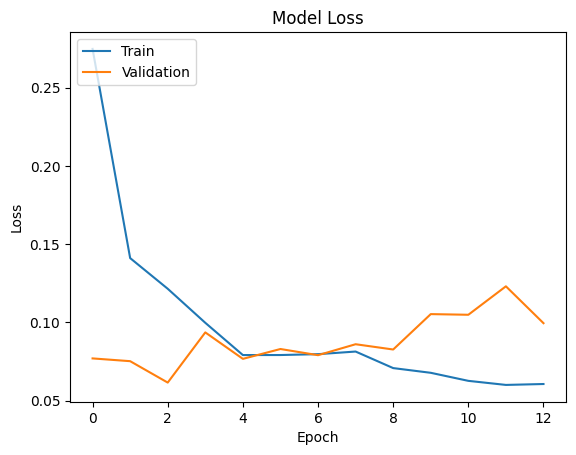

In [ ]:
# Plot the loss variable
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

There is an inherent flaw in gradient descent, in that it can trap itself into finding local minima of a function as opposed to finding the global minima. However, by using an amalgamation of all the partial derivatives of a function, this issue can usually be circumvented. There are several cost optimization methods that utilize this concept in machine learning, with the two most used methods being Stochastic Gradient Descent (SGD) and ADAM optimization. The simple amalgamation of all partial derivatives is the SGD. 

ADAM serves as an industry standard for optimization, and so the MLP network constructed for this report was defaulted to use this method. However, a second model was also run to compare the performance to SGD optimization. SGD provided similar performance to ADAM with regards to accuracy, but ADAM produced much higher loss values. Even more interestingly, SGD required significantly more training compared to ADAM before being subjugated to overfitting.

As part of data science practice, model performance needs to be retroactively observed to ensure there were no discrepancies in model performance. This is equally as important as testing the dataset, to ensure the model is functioning as expected. One of the biggest concerns at this level is that the model might have been trained to overfit on the data, resulting in exceptional performance within the training dataset, but heavily biased and skewed predictions for non-trained data. 

There are two methods to reduce the risk of overfitting. The first is the mathematic implementation of regularization, which adds a term to the cost function to penalize complexity. The model used for this report eschewed overfitting by utilizing a mechanical function of neural networks called “dropout layers”. Simply put, the model randomly ignores nodes with each epoch in different layers. By utilizing this technique, model performance in accuracy can be visualized in a training and validation set as a function of time. 


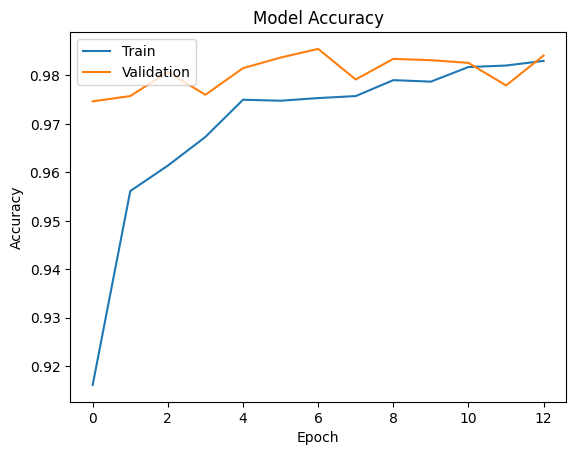

In [ ]:
# Plot the accuracy variable
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
# Evaluate the model
score = model.evaluate(x_test, y_test, batch_size=32, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 80.51515197753906
Test accuracy: 0.5402946472167969


In [ ]:
# Encode the free_annotation labels in the same way as the training dataset
y_test_encoded = pd.Categorical(y_test).codes

# Use the model to make predictions on the test dataset
y_pred = model.predict(x_test)

# Compute metrics to evaluate the performance of the model on the test dataset
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

print('Accuracy:', accuracy_score(y_test_encoded, np.argmax(y_pred, axis=1)))
print('Precision:', precision_score(y_test_encoded, np.argmax(y_pred, axis=1), average='weighted'))
print('Recall:', recall_score(y_test_encoded, np.argmax(y_pred, axis=1), average='weighted'))
print('F1 score:', f1_score(y_test_encoded, np.argmax(y_pred, axis=1), average='weighted'))

361/361 [==============================] - 1s 2ms/step
Accuracy: 0.5402946273830156
Precision: 0.5074201770133727
Recall: 0.5402946273830156
F1 score: 0.5107443918909853


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# Convert y_test to one-hot encoded format and obtain a class list
y_test_onehot = to_categorical(y_test)

classes = np.unique(name_list)

# Evaluate the model on the test dataset
y_pred_onehot = model.predict(x_test)
y_pred = np.argmax(y_pred_onehot, axis=1)
cm = confusion_matrix(np.argmax(y_test_onehot, axis=1), y_pred)

361/361 [==============================] - 1s 2ms/step


In [ ]:
# Free Up RAM
del history
gc.collect()

# Build the MLP model
model_2 = Sequential()
model_2.add(Dense(512, input_shape=(x_train.shape[1],), activation='relu'))
model_2.add(Dropout(0.5))
model_2.add(Dense(256, activation='relu'))
model_2.add(Dropout(0.5))
model_2.add(Dense(16, activation='softmax'))

# Compile the model
model_2.compile(loss='sparse_categorical_crossentropy', optimizer= SGD(learning_rate=0.001), metrics=['accuracy'])

# Train the model
early_stop = EarlyStopping(patience=10, verbose=1)
history_2 = model_2.fit(x_train, y_train, epochs=30, batch_size=32, validation_data=(x_val, y_val), callbacks=[early_stop])

clear_output()


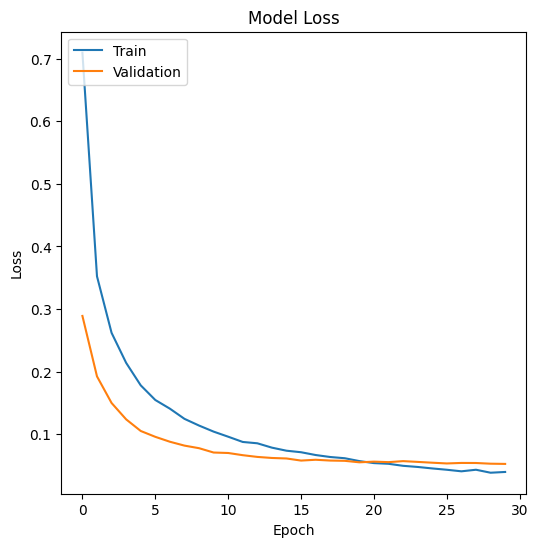

In [ ]:
# Plot the loss variable
plt.plot(history_2.history['loss'])
plt.plot(history_2.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

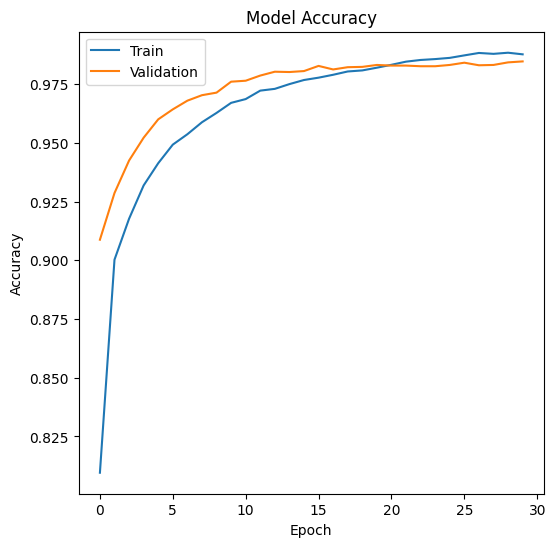

In [ ]:
# Plot the accuracy variable
plt.plot(history_2.history['accuracy'])
plt.plot(history_2.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
score_2 = model_2.evaluate(x_test, y_test, batch_size=32, verbose=0)
print('Test loss:', score_2[0])
print('Test accuracy:', score_2[1])

Test loss: 5.2665276527404785
Test accuracy: 0.5671576857566833


#Results

Since both datasets include only healthy patients, there should also be an understanding that this misclassification discrepancy is not an indication of pathologic illness.


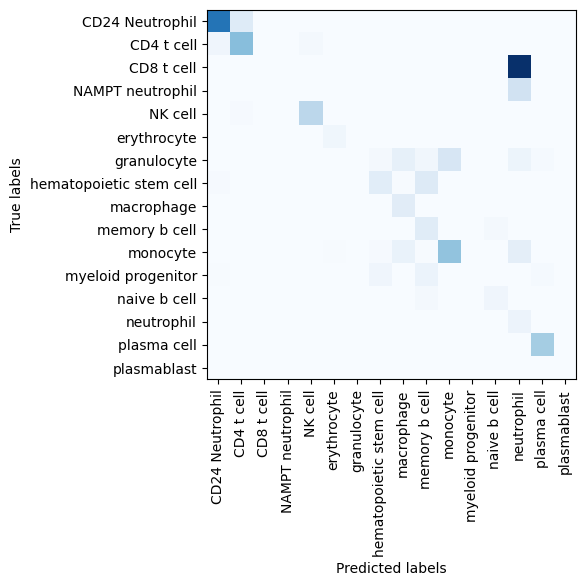

In [ ]:
# Plot the confusion matrix
plt.imshow(cm, cmap=plt.cm.Blues)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.rcParams["figure.figsize"] = (6,6)
plt.xticks(ticks=np.arange(len(classes)), labels=classes, rotation=90)
plt.yticks(ticks=np.arange(len(classes)), labels=classes)
#plt.colorbar()
plt.show()

The above graph is a representation of a typical Bioinformatics workflow end point. Ideally, a confusion matrix should have a solid diagonal line of squares from top left to bottom right, as this would indicate perfect predictions. When a confusion matrix skews away from this expectation, it is the responsibility of the researcher to provide reasoning and conduct further research to provide explanations for their findings. These discussions would not align with the purposes of this report, but a brief write-up to potentially explain the findings in Figure 3 is provided below.

The most mislabelled set was the cytotoxic T lymphocytes (also referred to as CD8 T cells) being predicted to be neutrophils. Both cell types are tasked with immune function through controlled killing of other cells. Neutrophils typically kill other cells in a non-targeted manner. When the body experiences localized inflammation, the first immune cell that is typically recruited in mass, is the neutrophil. It non-discriminantly kills cells that are identified as not belonging to the host body. Cytotoxic T cells are specialized killer cells. They are specifically designed to identify and kill host cells that might have been infected and misbehaving because of their infection. 

When assessing the confusion matrix, there are conclusions that can be extrapolated based on the understanding of these cell functions. First and foremost, both cells having similar functions and belonging to similar lineages is a good indication that the model is performing somewhat expected. Typical model performance should exceed 50% accuracy and is expected to approach as close to 100% as possible, without being subjected to overfitting. The accuracy findings for this project cannot yet be considered viable for further research, since they were rather low. Despite this fact, this model is at least shown to be performing within the realm of expectancy. Even at lower accuracies, models should not result in multiple misclassifications between tissue samples, especially between cells that are of different lineages and/or cell functions.

Without knowing the intricacies of the gene sequences involved, more research might be required to explain the misclassification. However, one such possibility might be that neutrophils or CD8 T cells could contain different gene sequence products (proteins) depending on whether they are present in the blood or in the bone marrow. These types of findings are integral to medical research because they provide new insight into cell function within the body. Such discoveries are the basis for new treatment regimens or therapy targets for diseases such as cancer or infections such as COVID-19. 

Mathematically, this model is not anywhere close to being usable for real world application. When attempting to add an additional three layers to the model, the result was massive losses in the testing data and below 50% accuracy. Typically, such findings would warrant a need for more training data, but such a task would be difficult due to computational limitations. At best, the model only succeeded in predicting 56% accuracy for the testing data. The addition of drop-out layers did not change the accuracy of the model, but did seem effective in reducing overfitting as expected. Machine learning academia suggests that the two best activation functions for multi-class problems were softmax and ReLu, which were used for this project (Bos & Schmidt-Hieber, 2022). When swapping the training and testing dataframes, the accuracy scores on the testing dataset do appear higher, at 75%. This might indicate that the model is over-learning somehow since the testing dataset has less data than the training dataset. The model seems quick to overfit at over 90% accuracy and infinitesimally small loss values during training. One crucial step missing in this whole process was dimensionality reduction through PCA. When attempting this step on RNAseq data, it introduced a lot of complications deeming training impossible. Dimensionality reduction would be a step in the right direction towards a more viable model, seeing as the model tends to perform better when it’s more simplified and protected against overfitting. Other optimizers could also be used instead of Adam, but seeing as switching to SGD resulted in minor changes in performance, this would not be the ideal starting point to tweak the model. Adjusting the number of nodes in the model did not seem to change the performance of the model either, so freely adjusting node counts is a viable option, ensuring that the last layer contains 16 nodes to represent 16 classes. Despite poor performance, this model is still oriented in the right direction, seeing as it consistently misclassifies CD8 T cells as neutrophils. This is a very specific finding that serves as evidence of consistency in model performance. In bioinformatics workflows, the removal of genes that do not have “high variability” is essential to preprocessing. When attempting this step, it introduced a lot of errors that prevented the model from being trained. Filtering highly variable genes, might result in significantly better accuracy scores, as the model might be incorrectly predicting cells that have poorly represented gene sequences. 
